In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install ucimlrepo openml certifi pyOpenSSL

## 1. Requirements

In [ ]:

import os
import certifi
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import random
import numpy as np
import warnings
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

import time

from sklearn.datasets import fetch_openml
from ucimlrepo import fetch_ucirepo

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
np.random.seed(42)

In [ ]:
start_time = time.time()

## 2. Set Args

In [ ]:
#theta = 7 # type: ignore
num_epochs = 50
dropout_ratio = 0.5

data_path = '/content/drive/MyDrive/MIDA-our/datas/dd2/Sonar.csv'

mechanism = 'mcar' #'mcar'
method = 'uniform' #'uniform'

test_size = 0.3
use_cuda = True
batch_size  = 4 # not in the paper

## 3. Prepare Data

In [ ]:
dataset = pd.read_csv(data_path, on_bad_lines='skip')
dataset[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


In [ ]:
datas = dataset.copy()

In [ ]:
# Test
def per_MissVal(df):
    # Calculer le nombre total de valeurs manquantes
    total_mv = df.isnull().sum().sum()
    # Calculer le nombre total de valeurs dans le DataFrame
    total_val = df.size
    # Calculer le pourcentage de valeurs manquantes
    perc = (total_mv / total_val) * 100
    return perc

In [ ]:
print("data missing values", per_MissVal(datas), "%")


data missing values 0.0 %


In [ ]:
missing_counts = datas.isnull().sum()
missing_percent = (missing_counts / len(datas)) * 100
missing_counts = missing_counts.fillna(0).astype(int)
print(missing_counts)

V1       0
V2       0
V3       0
V4       0
V5       0
        ..
V57      0
V58      0
V59      0
V60      0
Class    0
Length: 61, dtype: int64


In [ ]:
#print(missing_percent)

In [ ]:
# ---------------- Detect column types ----------------
numeric_features = datas.select_dtypes(include=["int64", "float64"]).columns.to_list()
categorical_features = datas.select_dtypes(include=["object", "category"]).columns.to_list()

# ---------------- Define numeric imputer using HistGradientBoostingRegressor ----------------
# Custom imputer using HistGradientBoostingRegressor for numeric data
class HGBRImputer:
    def __init__(self):
        self.models = {}
        self.features = None

    # Add y=None to match sklearn's fit signature
    def fit(self, X, y=None):
        self.features = X.columns
        for col in self.features:
            is_missing = X[col].isnull()
            if is_missing.sum() == 0:
                continue
            train_idx = ~is_missing
            # Fill missing values in predictors with median for training
            X_train = X.loc[train_idx].drop(columns=col).fillna(X.loc[train_idx].median())
            y_train = X.loc[train_idx, col]
            model = HistGradientBoostingRegressor(
                learning_rate = 0.1,
                max_depth = 15,
                min_samples_leaf = 30,
                l2_regularization = 0.1,
                max_bins = 255,
                scoring = 'neg_mean_squared_error',
                max_iter=100,
                max_leaf_nodes=31,
                random_state=42,
                early_stopping=True,
                validation_fraction=0.25,
                n_iter_no_change=10
            )
            model.fit(X_train, y_train)
            self.models[col] = model
        return self

    def transform(self, X):
        X_filled = X.copy()
        for col, model in self.models.items():
            missing_idx = X_filled[col].isnull()
            if missing_idx.sum() == 0:
                continue
            # Fill missing predictor features with median before prediction
            X_pred = X_filled.loc[missing_idx].drop(columns=col).fillna(X_filled.median())
            preds = model.predict(X_pred)
            X_filled.loc[missing_idx, col] = preds
        return X_filled


# ---------------- Define transformers ----------------

numeric_transformer = Pipeline(steps=[
    ("imputer", HGBRImputer()),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # handle missing categorical
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# ---------------- Column Transformer ----------------
transformers = []
if len(numeric_features) > 0:
    transformers.append(("num", numeric_transformer, numeric_features))
if len(categorical_features) > 0:
    transformers.append(("cat", categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(
    transformers=transformers,
    sparse_threshold=0
)

# ---------------- Full Pipeline ----------------
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# ---------------- Apply on dataset ----------------
# pipeline.fit(datas)
processed = pipeline.fit_transform(datas)

# Convert back to DataFrame with column names
all_features = []
if len(numeric_features) > 0:
    all_features.extend(numeric_features)
if len(categorical_features) > 0:
    all_features.extend(categorical_features)

df_processed = pd.DataFrame(processed, columns=all_features)

print(df_processed.head())

         V1        V2        V3        V4        V5        V6        V7  \
0  0.136431  0.156451  0.135677  0.035426  0.224956  0.237571  0.407468   
1  0.323009  0.221603  0.272011  0.150024  0.283033  0.666756  0.574405   
2  0.182153  0.246892  0.356110  0.243699  0.230028  0.585327  0.648810   
3  0.062684  0.070724  0.199737  0.034950  0.034999  0.071486  0.288149   
4  0.550885  0.282898  0.153088  0.079886  0.132640  0.147003  0.318182   

         V8        V9       V10  ...       V52       V53       V54       V55  \
0  0.340904  0.449282  0.285714  ...  0.027104  0.155844  0.435673  0.149660   
1  0.755458  0.483045  0.394537  ...  0.108417  0.218182  0.111111  0.199546   
2  0.819405  0.817859  0.869584  ...  0.319544  0.418182  0.248538  0.394558   
3  0.269239  0.077447  0.164593  ...  0.161198  0.080519  0.409357  0.179138   
4  0.531863  0.516659  0.621479  ...  0.032810  0.127273  0.277778  0.235828   

        V56       V57       V58       V59       V60  Class  
0  0.41

In [ ]:
missing_counts = df_processed.isnull().sum()
missing_percent = (missing_counts / len(df_processed)) * 100
missing_counts = missing_counts.fillna(0).astype(int)
print(missing_counts)

V1       0
V2       0
V3       0
V4       0
V5       0
        ..
V57      0
V58      0
V59      0
V60      0
Class    0
Length: 61, dtype: int64


In [ ]:
data = df_processed.values #datas.values
# data = df_small.values

if use_cuda and not torch.cuda.is_available():
    print("---"* 20)
    print("CUDA is not available. Switching to CPU.")
    use_cuda = False


rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-test_size))]
test_index = shuffled_index[int(rows*(1-test_size)):]


train_data = data[train_index, :]
test_data = data[test_index, :]

print("")
print(train_data[:5])
print("")
print(test_data[:5])

------------------------------------------------------------
CUDA is not available. Switching to CPU.

[[0.21386431 0.15302186 0.06537451 0.04018069 0.09865585 0.15130341
  0.24512987 0.20220507 0.36428254 0.43100243 0.26981426 0.34950176
  0.32172161 0.19655564 0.11315077 0.10940362 0.0556419  0.14337662
  0.13296865 0.09460616 0.         0.16215111 0.3683374  0.55916402
  0.64928279 0.72177553 0.8469377  0.90582544 0.8648539  0.88196442
  0.93547684 0.9119299  0.70639504 0.63465819 0.61675361 0.68225806
  0.76383118 0.61328897 0.56441071 0.65381264 0.60648523 0.5993895
  0.65007112 0.74362278 0.83977822 0.65866703 0.70210069 0.83228512
  0.72034326 0.51393939 0.26992032 0.27389444 0.16883117 0.1754386
  0.1814059  0.21794872 0.20170455 0.08924485 0.14876033 0.03464203
  0.        ]
 [0.20870206 0.26103729 0.2086071  0.20518307 0.39259447 0.58908895
  0.57981602 0.43616318 0.20494595 0.10567711 0.31008082 0.49956038
  0.37325464 0.2632773  0.32159695 0.4246896  0.54802611 0.43428571
 

In [ ]:
df0 = pd.DataFrame(train_data)
df1 = pd.DataFrame(test_data)
print("train_data missing values", per_MissVal(df0), "%", "--", "test_data missing values", per_MissVal(df1), "%")

train_data missing values 0.0 % -- test_data missing values 0.0 %


In [ ]:
print("number of rows and columns", data.shape)
print()
print("size of the dataset", data.size)
#n = data.shape
#print(n)
#print(n[1])

number of rows and columns (208, 61)

size of the dataset 12688


In [ ]:
def missing_method(raw_data, mechanism='mcar', method='uniform') :

    data = raw_data.copy()
    rows, cols = data.shape

    # missingness threshold
    t = 0.1

    if mechanism == 'mcar' :

        if method == 'uniform' :
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)
            data[mask] = 0

        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where v<=t
            mask = (v<=t)*c
            data[mask] = 0

        else :
            print("Error : There are no such method")
            raise

    elif mechanism == 'mnar' :

        if method == 'uniform' :
            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)
            data[mask] = 0


        elif method == 'random' :
            # only half of the attributes to have missing value
            missing_cols = np.random.choice(cols, cols//2)
            c = np.zeros(cols, dtype=bool)
            c[missing_cols] = True

            # randomly sample two attributes
            sample_cols = np.random.choice(cols, 2)

            # calculate ther median m1, m2
            m1, m2 = np.median(data[:,sample_cols], axis=0)
            # uniform random vector
            v = np.random.uniform(size=(rows, cols))

            # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
            m1 = data[:,sample_cols[0]] <= m1
            m2 = data[:,sample_cols[1]] >= m2
            m = (m1*m2)[:, np.newaxis]

            mask = m*(v<=t)*c
            data[mask] = 0

        else :
            print("Error : There is no such method")
            raise

    else :
        print("Error : There is no such mechanism")
        raise

    return data, mask

In [ ]:
missed_data, mask = missing_method(test_data, mechanism=mechanism, method=method)
#print(mask)
missed_data = torch.from_numpy(missed_data).float()
train_data = torch.from_numpy(train_data).float()

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

## 4. Define Model

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu") #torch.device("cpu")

In [ ]:
print(f"Using device: {device}")

# Vérifier si le device est bien CUDA ou CPU
if device.type == "cuda":
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA not available, using CPU.")



Using device: cpu
CUDA not available, using CPU.


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        #pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, dim):
        super(Autoencoder, self).__init__()
        n = data.shape
        feature_size= n[1] #11#14
        #num_layers=1
        dropout=0.1
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=32, nhead=2, dropout=dropout, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=8)
        self.transformer_encoder1 = nn.TransformerEncoder(self.encoder_layer, num_layers=16)
        self.transformer_encoder2 = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.decoder = nn.Linear(32,feature_size)

        self.conv1 = nn.Conv1d(feature_size, 32, kernel_size=1)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=1)

        self.src_mask = None
#         self.fc2 = nn.Linear(32, 3000)
    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
    def forward(self, x):
        print('in0 ',x.shape)
        x = self.pos_encoder(x)
        print('in1 ',x.shape)
        x=torch.permute(x, (0, 2, 1))
        print('in2 ',x.shape)
        print('in3 ',x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x=torch.permute(x, (0, 2, 1))
        print('ink ',x.shape)
        src=x
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        #src = self.pos_encoder(src)
        output = self.transformer_encoder1(src,self.src_mask)
        output = self.decoder(output)#+output1+output2)
        print(output.shape,output[:, -1, :].shape)
        return output[:, -1, :]#output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

## 5. Define the autoencoder Model

In [ ]:
model = Autoencoder(dim=cols).to(device)

## 6. Define Loss and Optimizer

In [ ]:
loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), momentum=0.99, lr=0.01, nesterov=True)

## 7. Train Model

In [ ]:
cost_list = []
early_stop = False

for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size

    for i, batch_data in enumerate(train_loader):

        batch_data = batch_data.to(device)

        reconst_data = model(batch_data)
        cost = loss(reconst_data, batch_data)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        divisor = max(total_batch // 2, 1)

        if (i+1) % (total_batch//2) == 0:
        #if (i+1) % (divisor) == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.6f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

        # early stopping rule 1 : MSE < 1e-06
        if cost.item() < 1e-06 :
            early_stop = True
            break

#         early stopping rule 2 : simple moving average of length 5
#         sometimes it doesn't work well.
#         if len(cost_list) > 5 :
#            if cost.item() > np.mean(cost_list[-5:]):
#                early_stop = True
#                break

        cost_list.append(cost.item())

    if early_stop :
        break

print("Learning Finished!")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
in2  torch.Size([4, 61, 4])
in3  torch.Size([4, 61, 4])
ink  torch.Size([4, 4, 32])
torch.Size([4, 4, 61]) torch.Size([4, 61])
in0  torch.Size([4, 61])
in1  torch.Size([4, 4, 61])
in2  torch.Size([4, 61, 4])
in3  torch.Size([4, 61, 4])
ink  torch.Size([4, 4, 32])
torch.Size([4, 4, 61]) torch.Size([4, 61])
in0  torch.Size([4, 61])
in1  torch.Size([4, 4, 61])
in2  torch.Size([4, 61, 4])
in3  torch.Size([4, 61, 4])
ink  torch.Size([4, 4, 32])
torch.Size([4, 4, 61]) torch.Size([4, 61])
in0  torch.Size([4, 61])
in1  torch.Size([4, 4, 61])
in2  torch.Size([4, 61, 4])
in3  torch.Size([4, 61, 4])
ink  torch.Size([4, 4, 32])
torch.Size([4, 4, 61]) torch.Size([4, 61])
in0  torch.Size([4, 61])
in1  torch.Size([4, 4, 61])
in2  torch.Size([4, 61, 4])
in3  torch.Size([4, 61, 4])
ink  torch.Size([4, 4, 32])
torch.Size([4, 4, 61]) torch.Size([4, 61])
in0  torch.Size([4, 61])
in1  torch.Size([4, 4, 61])
in2  torch.Size([4, 61

## 8. Test Model

In [ ]:


model.eval()
#filled_data = model(missed_data.to(device))
#filled_data = filled_data.cpu().detach().numpy()

with torch.no_grad():   # safer: avoid gradients
    filled_data = model(missed_data.to(device))
    filled_data = filled_data.cpu().detach().numpy()

rmse_sum = 0
num_valid_columns = 0

for i in range(cols) :
    if mask[:,i].sum() > 0 :
        y_actual = test_data[:,i][mask[:,i]]
        y_predicted = filled_data[:,i][mask[:,i]]

        rmse = sqrt(mean_squared_error(y_actual, y_predicted))
        rmse_sum += rmse
        num_valid_columns += 1

#print("RMSE_SUM :", rmse_sum)
print(f'RMSE_SUM: {rmse_sum:.3f}')
average_rmse = rmse_sum / num_valid_columns
print()
print(f'Average RMSE: {average_rmse:.3f}')

in0  torch.Size([63, 61])
in1  torch.Size([63, 63, 61])
in2  torch.Size([63, 61, 63])
in3  torch.Size([63, 61, 63])
ink  torch.Size([63, 63, 32])
torch.Size([63, 63, 61]) torch.Size([63, 61])
RMSE_SUM: 12.191

Average RMSE: 0.200


In [ ]:
from sklearn.metrics import mean_squared_error
#from numpy import sqrt

mse_sum = 0
num_valid_columns = 0  # To count columns with valid data

for i in range(cols):
    if mask[:, i].sum() > 0:  # Check if there are any missing values
        y_actual = test_data[:, i][mask[:, i]]
        y_predicted = filled_data[:, i][mask[:, i]]

        # Calculate RMSE for the current column
        mse = mean_squared_error(y_actual, y_predicted)
        mse_sum += mse
        num_valid_columns += 1  # Increment valid column count

# Calculate average RMSE if there are valid columns
if num_valid_columns > 0:
    #print("MSE sum:", mse_sum)
    print(f'MSE (sum) Score: {mse_sum:.3f}')
    print("-------")
    average_mse = mse_sum / num_valid_columns
    #print("Average MSE:", average_mse)
    print(f'Average MSE: {average_mse:.3f}')
else:
    print("No valid columns to calculate MSE.")

MSE (sum) Score: 2.985
-------
Average MSE: 0.049


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_sum = 0
num_valid_columns = 0

for i in range(cols):
    if mask[:, i].sum() > 0:
        y_actual = test_data[:, i][mask[:, i]]
        y_predicted = filled_data[:, i][mask[:, i]]

        mae = mean_absolute_error(y_actual, y_predicted)
        mae_sum += mae
        num_valid_columns += 1

print(f'MAE (sum) Score: {mae_sum:.3f}')
print("------------")
average_mae = mae_sum / num_valid_columns
print(f'Average MAE Score: {average_mae:.3f}')

MAE (sum) Score: 10.280
------------
Average MAE Score: 0.169


In [ ]:
from sklearn.metrics import accuracy_score

acc_sum = 0
count = 0

for i in range(cols):
    if mask[:, i].sum() > 0:  # only evaluate where ground truth exists
        y_actual = test_data[:, i][mask[:, i]]
        y_predicted = filled_data[:, i][mask[:, i]]

        # Convert continuous values to discrete labels by rounding or thresholding
        # Here we round values to nearest integer as an example
        y_actual_discrete = np.rint(y_actual).astype(int)
        y_predicted_discrete = np.rint(y_predicted).astype(int)

        # Now compute accuracy_score on discrete labels
        acc = accuracy_score(y_actual_discrete, y_predicted_discrete)
        acc_sum += acc
        count += 1

if count > 0:
    avg_acc = acc_sum / count
    print(f'Accuracy Score (sum): {acc_sum:.3f}')
    print(f'Average Accuracy Score: {avg_acc:.3f}')
else:
    print("No valid columns for Accuracy calculation.")

Accuracy Score (sum): 49.458
Average Accuracy Score: 0.811


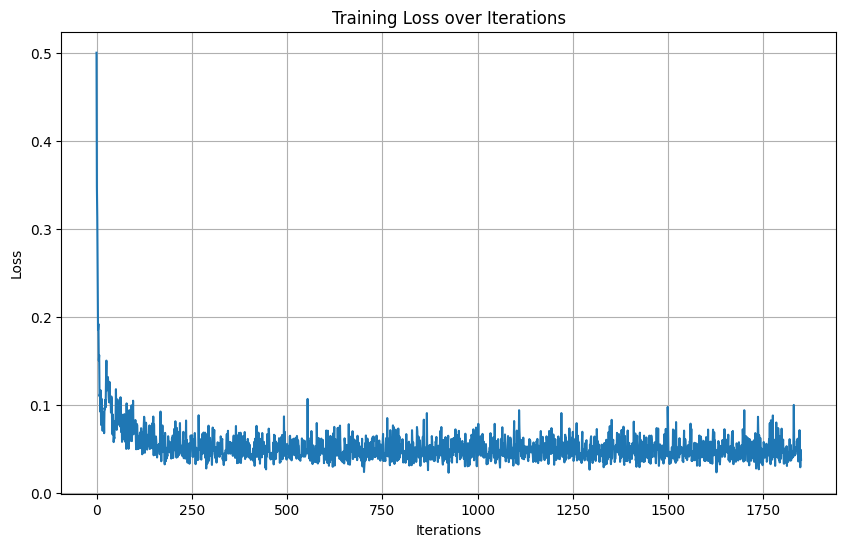

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.grid(True)
plt.show()

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 142.2809820175171 seconds ---
